In [1]:
import pandas as pd
import torch
import torch.nn as nn
import scipy.stats as stats
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import sys

# libraries for partitioning and batching the data
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
df = pd.read_csv("default of credit card clients.csv")
data = df.drop('Y', axis=1)
labels = df[['Y']]

In [4]:
cols2zscore = data.keys()
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data = torch.tensor(data.values).float()
labels = torch.tensor(labels.values).float()

#X = data
#y = labels

In [5]:
trainsize = 0.6
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=trainsize)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset = TensorDataset(test_data, test_labels)

In [6]:
batchsize = 8192
# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=batchsize, shuffle=True, drop_last=False)

In [7]:
print(len(train_loader))


3


In [8]:
def createANNmodel(momentum):

  # model architecture
  ANN = nn.Sequential(
      nn.Linear(23,64),  # input layer
      nn.Tanh(),        # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.Tanh(),        # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.Tanh(),        # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.Tanh(),        # activation unit
      nn.Linear(64,1),   # output unit
      nn.Sigmoid(),     # final activation unit
        )

  # loss function
  lossfun = nn.BCELoss() # but better to use BCEWithLogitsLoss

  # optimizer
  optimizer = torch.optim.SGD(ANN.parameters(),lr=0.70710678, momentum=momentum)

  # model output
  return ANN,lossfun,optimizer

In [9]:
# Define a global parameter 'numepochs' with a value of 500, representing the number of training epochs.
numepochs = 200

# Define a function 'trainTheModel' to train the neural network.
def trainTheModel():

  # Initialize lists to store training and test accuracies, as well as losses during training.
  trainAcc = []
  testAcc  = []
  losses   = []

  # Loop over epochs (training iterations).
  for epochi in range(numepochs):
    
    if epochi % 100 == 0:
        print(epochi)
    # Activate training mode for the neural network.
    ANN.train()

    # Initialize lists to store accuracy and loss for each batch during training.
    batchAcc  = []
    batchLoss = []

    # Loop over training data batches.
    for X,y in train_loader:

      # Perform a forward pass through the neural network.
      yHat = ANN(X)
      #print(yHat)
      # Calculate the loss using the specified loss function.
      loss = lossfun(yHat,y)
      
      # Clear previous gradient calculations.
      optimizer.zero_grad()
      
      # Perform backpropagation to compute gradients.
      loss.backward()
      
      # Update the model's parameters using the optimizer.
      optimizer.step()

      # Compute training accuracy for this batch and append to 'batchAcc'.
      #batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchAcc.append( 100*torch.mean(((yHat.round()) == y).float()) )
      
      # Append the loss value for this batch to 'batchLoss'.
      batchLoss.append( loss.item() )
    # End of batch loop...

    # Calculate the average training accuracy for this epoch and append to 'trainAcc'.
    trainAcc.append( np.mean(batchAcc) )

    # Append the average loss for this epoch to 'losses'.
    losses.append( np.mean(batchLoss) )

    # Test accuracy on the validation set.
    
    # Extract X,y from the test dataloader.
    X,y = next(iter(test_loader))

    # Activate evaluation mode (no gradient computation) for the neural network.
    ANN.eval()

    # Perform forward pass for the test data.
    with torch.no_grad():
      #predictions = torch.argmax( ANN(X),axis=1 )
      predictions = ANN(X)
      #print(predictions)
    
    # Compute accuracy on the test data and append to 'testAcc'.
    #testAcc.append( 100*torch.mean((predictions == y).float()).item() )
    testAcc.append( 100*torch.mean(((predictions.round()) == y).float()) )
    #rint(predictions)
    
  
  # Function output: training accuracies, test accuracies, and losses over epochs.
  return trainAcc, testAcc, losses

In [21]:
# Create a new model, loss function, and optimizer.
ANN, lossfun, optimizer = createANNmodel(0.25)
# Train the model using the current batch size.
trainAcc, testAcc, losses = trainTheModel()


0
100


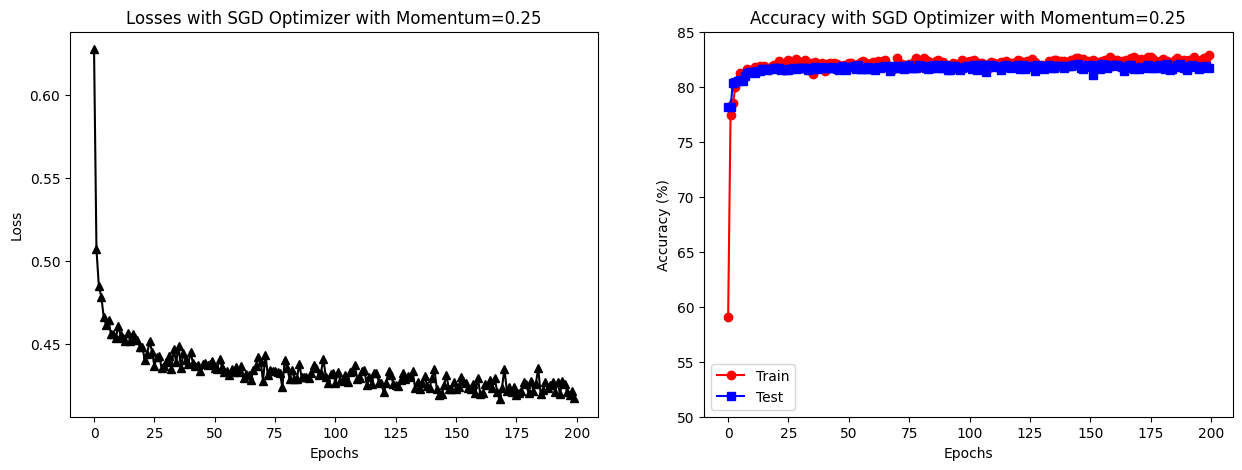

In [26]:


# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with SGD Optimizer with Momentum=0.25')

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with SGD Optimizer with Momentum=0.25')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([50,85])

plt.show()

In [30]:
print("Training accuracy: " + str(trainAcc[199]))

Training accuracy: 82.8903


In [31]:
print(np.mean(trainAcc[-10:]))

82.42247


In [27]:
print("Testing accuracy: " + str(testAcc[199]))

Testing accuracy: tensor(81.7000)


In [29]:
print(np.mean(testAcc[-10:]))

81.7775


In [10]:
# Variables to loop over
momenta = np.linspace(0.00,0.999,5)

momenta

array([0.     , 0.24975, 0.4995 , 0.74925, 0.999  ])

In [11]:
# Initialize performance matrix
finalPerformance = np.zeros((len(momenta)))
finalPerformance

array([0., 0., 0., 0., 0.])

In [12]:
results = np.zeros((numepochs, len(momenta), 3))
results

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], shape=(200, 5, 3))

In [13]:


# Explanation:
# In this code snippet, we define a range of learning rates and a list of optimizer types to be tested in an experiment.



# Explanation:
# We initialize a matrix called 'finalPerformance' with dimensions (number of learning rates, number of optimizer types) to store the results of an experiment. Each row corresponds to a different learning rate, and each column corresponds to a different optimizer type.

# Now for the experiment!

for idx, mom in enumerate(momenta):

        # Explanation:
        # We iterate through each combination of optimizer type and learning rate to conduct an experiment. Inside the loop, we call a function (presumably 'function2trainTheModel') to train a neural network model with the specified optimizer type and learning rate.

    # Create a new model, loss function, and optimizer.
    ANN, lossfun, optimizer = createANNmodel(mom)
    # Train the model using the current batch size.
    trainAcc, testAcc, losses = trainTheModel()

        # Explanation:
        # We store the training accuracy, test accuracy, and loss values obtained during training.

    results[:, idx, 0] = losses  # Column 0 stores losses
    results[:, idx, 1] = trainAcc  # Column 1 stores training accuracy
    results[:, idx, 2] = testAcc  # Column 2 stores test accuracy

    
        # Explanation:
        # We compute the mean test accuracy of the last 10 data points from the 'testAcc' list and store it in the 'finalPerformance' matrix.

# Explanation:
# After the loop completes, the 'finalPerformance' matrix contains the average test accuracy values for different combinations of learning rates and optimizer types, providing insights into the performance of different configurations in the experiment.


0
100
0
100
0
100
0
100
0
100


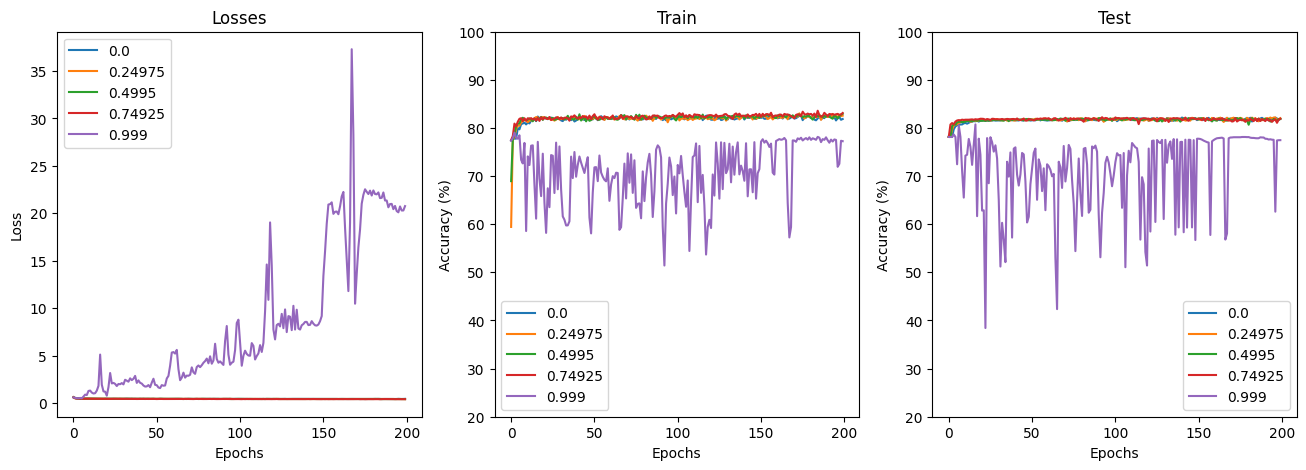

In [14]:
fig,ax = plt.subplots(1,3,figsize=(16,5))

for i in range(3):
  ax[i].plot(results[:,:,i])
  ax[i].legend(momenta)
  ax[i].set_xlabel('Epochs')
  if i==0:
    ax[i].set_ylabel('Loss')
  else:
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([20,100])

ax[0].set_title('Losses')
ax[1].set_title('Train')
ax[2].set_title('Test')

plt.show()

In [ ]:
finalPerformance[idx_l] = np.mean(testAcc[-10:])